Index(['gs_name', 'distance_km', 'elevation', 'time', 'rssi', 'snr', 'crc'], dtype='object')
1 -132.93696860947608 -130.5
2 -140.16810186937317 -121.5
3 -133.25894356187308 -105.0
4 -132.79142859204592 -134.75
5 -133.1827510589378 -137.0
7 -135.45867423463864 -135.75
8 -137.89836105432352 -140.25
9 -138.07443241372994 -143.0
10 -137.89836105432352 -141.75
11 -131.92211471642412 -141.0
13 -137.17218403769647 -142.25
14 -137.41060402853032 -140.75
15 -137.26833877949457 -132.25
17 -131.23178681464566 -133.0
18 -131.03804146658308 -110.5
19 -132.2406330255332 -141.25
20 -132.53415038632983 -112.0
21 -136.12896666620412 -134.0
22 -132.88432669296122 -141.25
23 -131.00532621269787 -138.0
24 -133.23362025053058 -131.75
25 -132.2548372635933 -121.25
26 -134.88041555637972 -140.75
27 -135.31019387305446 -132.75
28 -135.18955457765622 -136.75
29 -132.1261550634851 -101.75
30 -131.81826851367987 -139.5
31 -132.64340830035985 -127.75
32 -133.9978407779713 -144.25
33 -132.64340830035985 -134.75
34

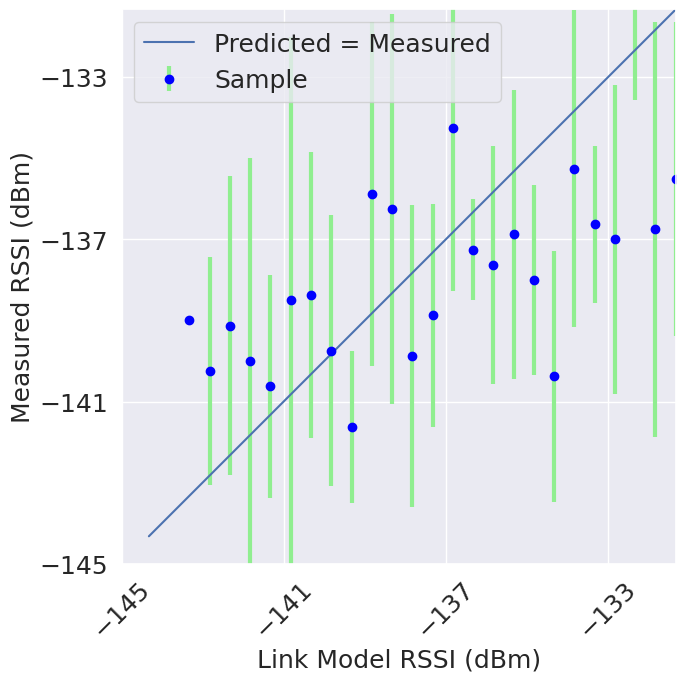

In [1]:

FREQUENCY = 401.7e6
BANDWIDTH = 125e3 

import scipy
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()


def calcuate_model(distance, elev, lat=0, long=0):
    fsl = 20 * np.log10(distance) + 20 * np.log10(FREQUENCY) + 20 * np.log10(4 * np.pi / 3e8)
    return 8 -fsl

data = pd.read_csv('tinyGsData.csv')
print(data.keys())
data = data[data['crc'] == 0]

theory = []
val = []

for id, row in data.iterrows():
    snr = calcuate_model(1000*row['distance_km'], row['elevation'])
    theory.append(snr)
    val.append(row['rssi'])
    print(id, snr, row['rssi'])

theory = np.array(theory)
val = np.array(val)
diff = np.array(theory) - np.array(val)

diffInds = np.arange(len(diff))
diff = diff[diffInds]
print("Mean:", np.mean(diff), "Std:", np.std(diff))

theory = theory[diffInds]
val = val[diffInds]

#let's bin theory every 1 dB and plot the mean and std of the real world values
bins = np.arange(min(theory), max(theory), .5)
inds = np.digitize(theory, bins)
means = []
stds = []
for i in range(1, len(bins)):
    means.append(np.median(val[inds == i]))
    stds.append(scipy.stats.iqr(val[inds == i])/2)

plt.figure(figsize=(7,7))
#let's do a histogram where x axis is theory and y axis is real world values. Let's draw the mean and an error bar for the std
lines = plt.errorbar(bins[2:], means[1:], yerr=stds[1:], fmt='o', label='Sample', color='blue', ecolor='lightgreen', elinewidth=3, capsize=0)
#set the y axis to be the same as the x axis
plt.plot([min(bins), max(bins)], [min(bins), max(bins)], label='Predicted = Measured')
#make the ticks on the x and y axis the same
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([min(bins), max(bins)])
plt.ylim([min(bins), max(bins)])

#find the r squared value for the y=x line

plt.legend()
plt.tick_params(axis='both', which='major',labelsize=18)
#make a tick on the x axis every 2 dB
plt.xticks(np.arange(-145, -130, 4))
plt.yticks(np.arange(-145, -130, 4))
plt.xticks(rotation=45)
plt.legend(fontsize=18, loc='upper left')
plt.xlabel('Link Model RSSI (dBm)',fontsize=18)
plt.ylabel('Measured RSSI (dBm)',fontsize=18)
plt.tight_layout()
#plt.savefig('linkModel.png')

